# Compare a few regional projections from the RECEIPT project

In [5]:
import sys
sys.path.append('../code')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import func_postpro as pp

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [32]:
# Define a dataframe of relevant locations

slr_2120_df = pd.DataFrame(index=['Xynthia', 'Xaver', 'Emilia-Romagna'])

slr_2120_df['Period'] = ['2010-2120', '2013-2120', '2002-2120']
slr_2120_df['Longitude'] = [-2.5, 8.5, 12.5]
slr_2120_df['Latitude'] = [45.5, 54.5, 44.5]

### Build a common dataset including all projections

In [6]:
data_dir = '../outputs/data_RECEIPT_D73/'
proj_names = ['Low', 'Medium', 'High']
suff = 'SeaLevelMap_RECEIPT_D73_'
proj_files = [f'{suff}LowMed_ssp126_GISS-E2-1-G_Perc5_2006_2125.nc',
              f'{suff}LowMed_ssp245_mean_Perc50_2006_2125.nc',
              f'{suff}High_ssp585_UKESM1-0-LL_Perc95_2006_2125.nc']

proj_ds_list = []
for i in range(len(proj_files)):
    ds = xr.open_dataset(f'{data_dir}{proj_files[i]}')
    ds = ds.expand_dims({'proj': [proj_names[i]]})
    proj_ds_list.append(ds)

proj_ds = xr.concat(proj_ds_list, dim='proj')

The data normally starts in 2006 but we linearly extrapolate to 2002 because this is the date of flooding in Emilia-Romagna

In [7]:
new_time = np.concatenate([np.array([2002]), proj_ds.time.values]) 
proj_ds = proj_ds.interp(time=new_time, method="linear", kwargs={"fill_value": "extrapolate"} )


In [8]:
proj_ds.time.values

array([2002, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
       2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037,
       2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048,
       2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059,
       2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070,
       2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081,
       2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092,
       2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103,
       2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114,
       2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125])

In [9]:
# Take the mean over a region
# lon_min, lon_max, lat_min, lat_max = pp.define_area('knmi14_reg')
lon_min, lon_max, lat_min, lat_max = 6, 9, 53, 55 # German coast for Xaver
proj_mean_ds = proj_ds.sel(lat=slice(lat_min, lat_max), 
                           lon=slice(lon_min, lon_max)
                          ).mean(dim=['lat', 'lon'])

# Select one grid cell
# lon_s, lat_s = 7.5, 54.5
# proj_mean_ds = proj_ds.sel(lat=lat_s, lon=lon_s, method='nearest')

In [10]:
proj_mean_ds

<xarray.Dataset>
Dimensions:             (proc_s: 8, proj: 3, time: 121)
Coordinates:
  * proj                (proj) <U6 'Low' 'Medium' 'High'
  * proc_s              (proc_s) object 'Stero-dynamics' 'Glaciers' ... 'GIA'
  * time                (time) int64 2002 2006 2007 2008 ... 2122 2123 2124 2125
Data variables:
    slc                 (proj, time, proc_s) float64 0.4585 0.4095 ... 13.58
    TotalSL             (proj, time) float64 1.657 3.036 3.381 ... 236.7 233.1
    area_weighted_mean  (proj, time) float64 1.205 2.367 2.657 ... 231.3 235.9

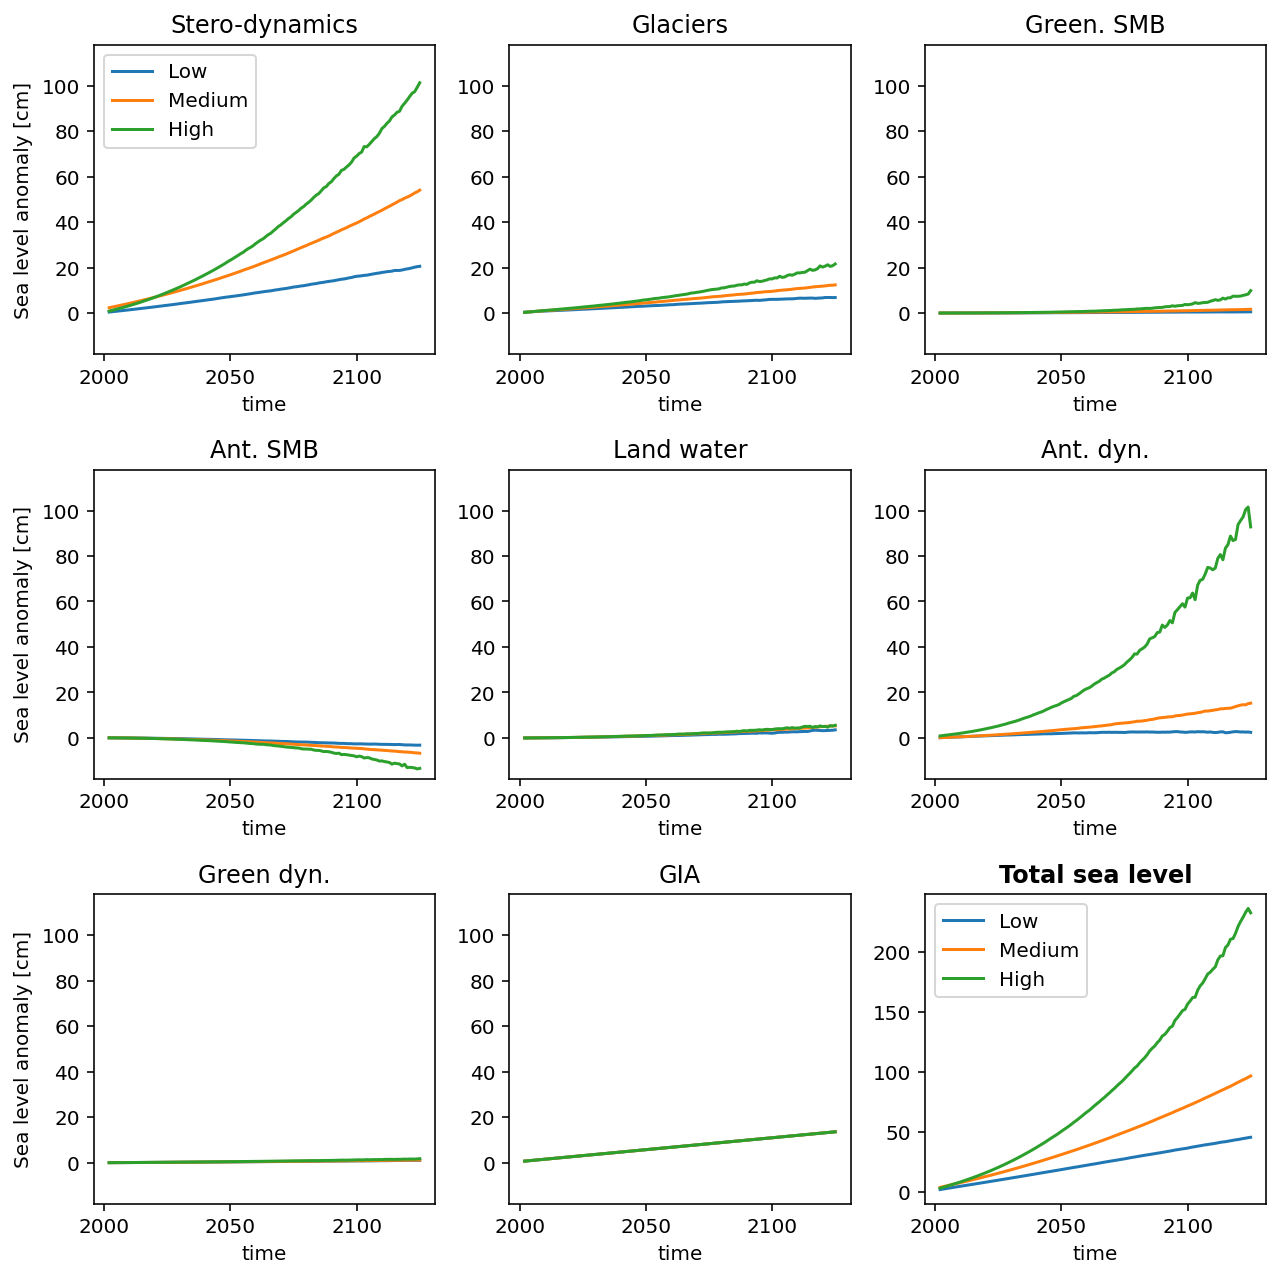

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,9))

for i in range(len(proj_mean_ds.proc_s)):
    proj_mean_ds.slc.isel(proc_s=i).plot.line(x='time', ax=axes.flat[i])
    axes.flat[i].set_title(proj_mean_ds.proc_s[i].values)
    axes.flat[i].set_ylim(-18,118)
    legend = axes.flat[i].get_legend()
    legend.set_title('')

    if i>0:
        legend.remove()

proj_mean_ds.TotalSL.plot.line(x='time', ax=axes.flat[-1])
axes.flat[-1].set_title('Total sea level', fontweight='bold')
legend = axes.flat[-1].get_legend()
legend.set_title('')

for i in range(3):
    axes[i,0].set_ylabel('Sea level anomaly [cm]')
    axes[i,1].set_ylabel('')
    axes[i,2].set_ylabel('')

plt.tight_layout()

#plt.savefig(f'../figures/CompContrib_Xaver.pdf', dpi=100)

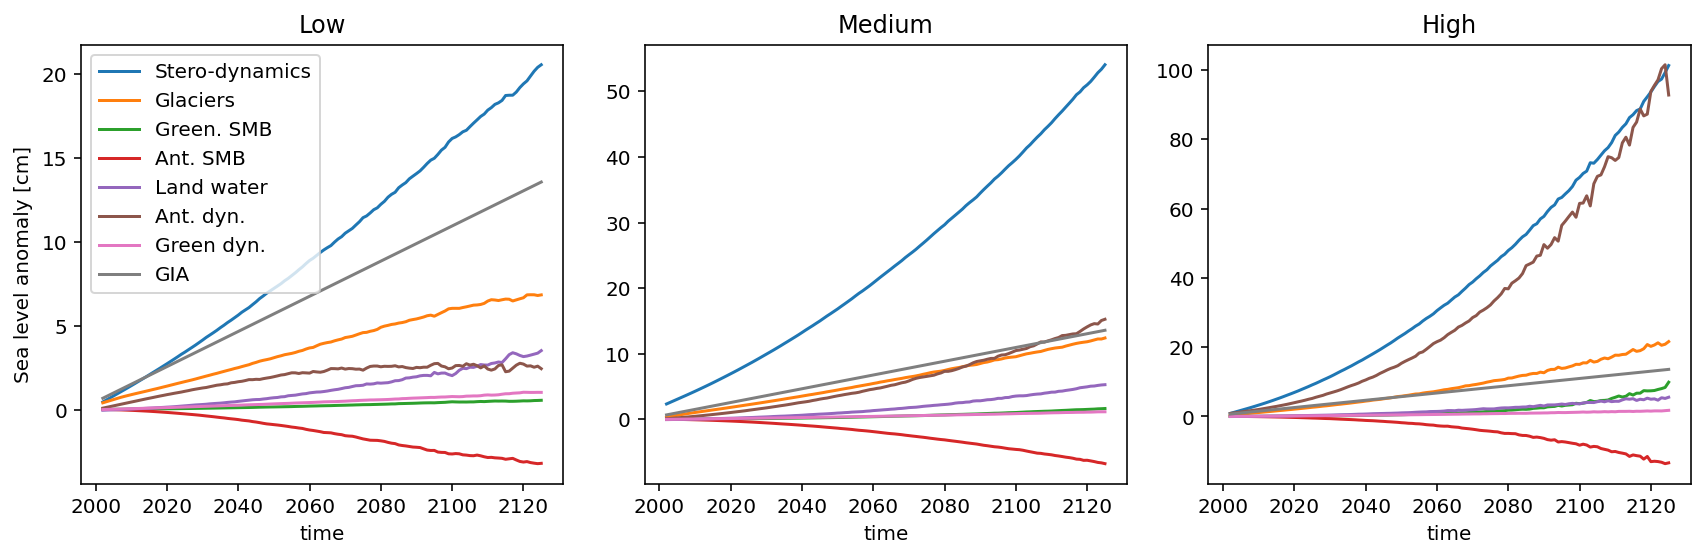

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4))

for i in range(len(proj_mean_ds.proj)):
    proj_mean_ds.slc.isel(proj=i).plot.line(x='time', ax=axes[i])
    axes[i].set_title(proj_mean_ds.proj[i].values)

    legend = axes[i].get_legend()
    legend.set_title('')
    
    if i==0:
        axes[i].set_ylabel('Sea level anomaly [cm]')
    else:
        axes[i].set_ylabel('')
        legend.remove()

plt.tight_layout()

#plt.savefig(f'../figures/CompScen_Xaver.pdf', dpi=100)

In [13]:
legend = axes[0].get_legend()
legend.set_title('test')

### Maps of future sea level

In [14]:
proj_map_ds = proj_ds.TotalSL.sel(time=slice(2120,2125)).mean(dim='time')

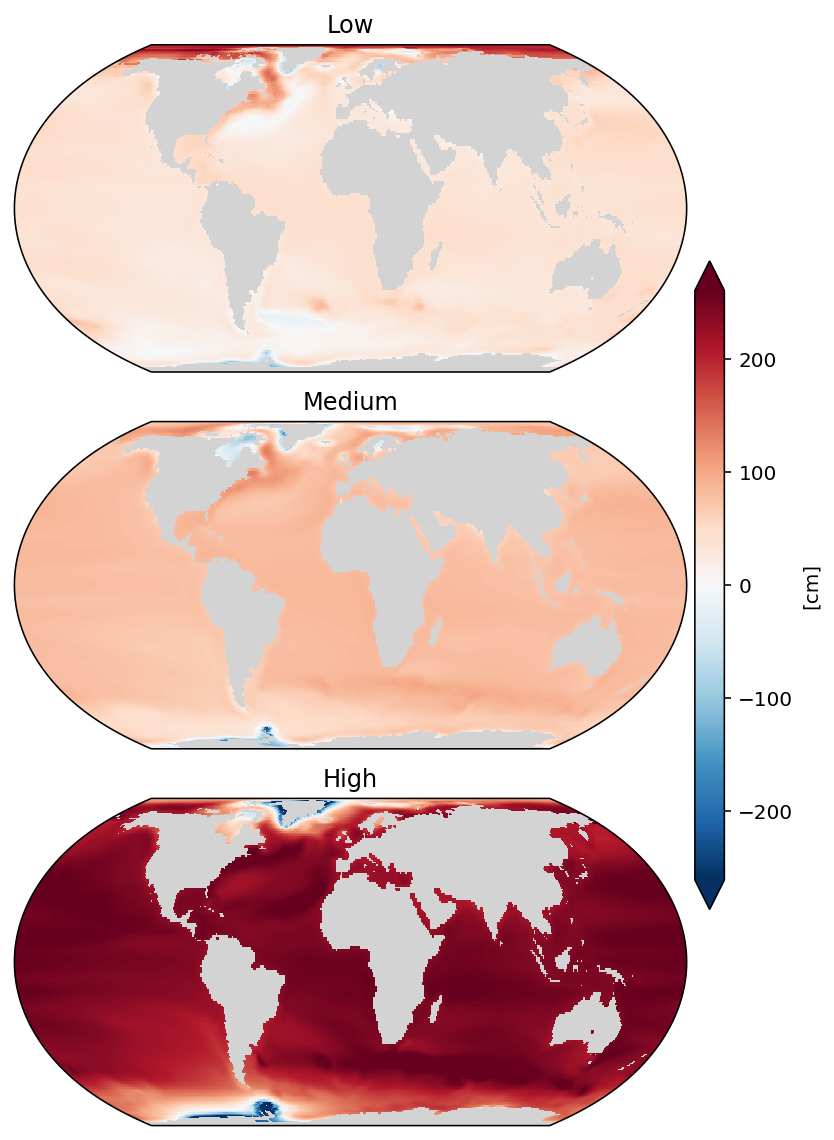

In [15]:
g = proj_map_ds.plot(
    col='proj',
    col_wrap=1,
    figsize=(6,8),
    #Projections options: PlateCarree, Mollweide, Robinson, EckertIV, EqualEarth
    subplot_kws=dict(projection=ccrs.EqualEarth(), facecolor="lightgray"),
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'orientation': 'vertical', 'label': '[cm]', 'pad': 0.01, 'shrink':0.6},
    robust=True
    )

for i in range(3):
    g.axes[i,0].set_title(proj_names[i]) #Index of axis is line,column 

#plt.savefig(f'../figures/CompMapProj_world.pdf', dpi=100)

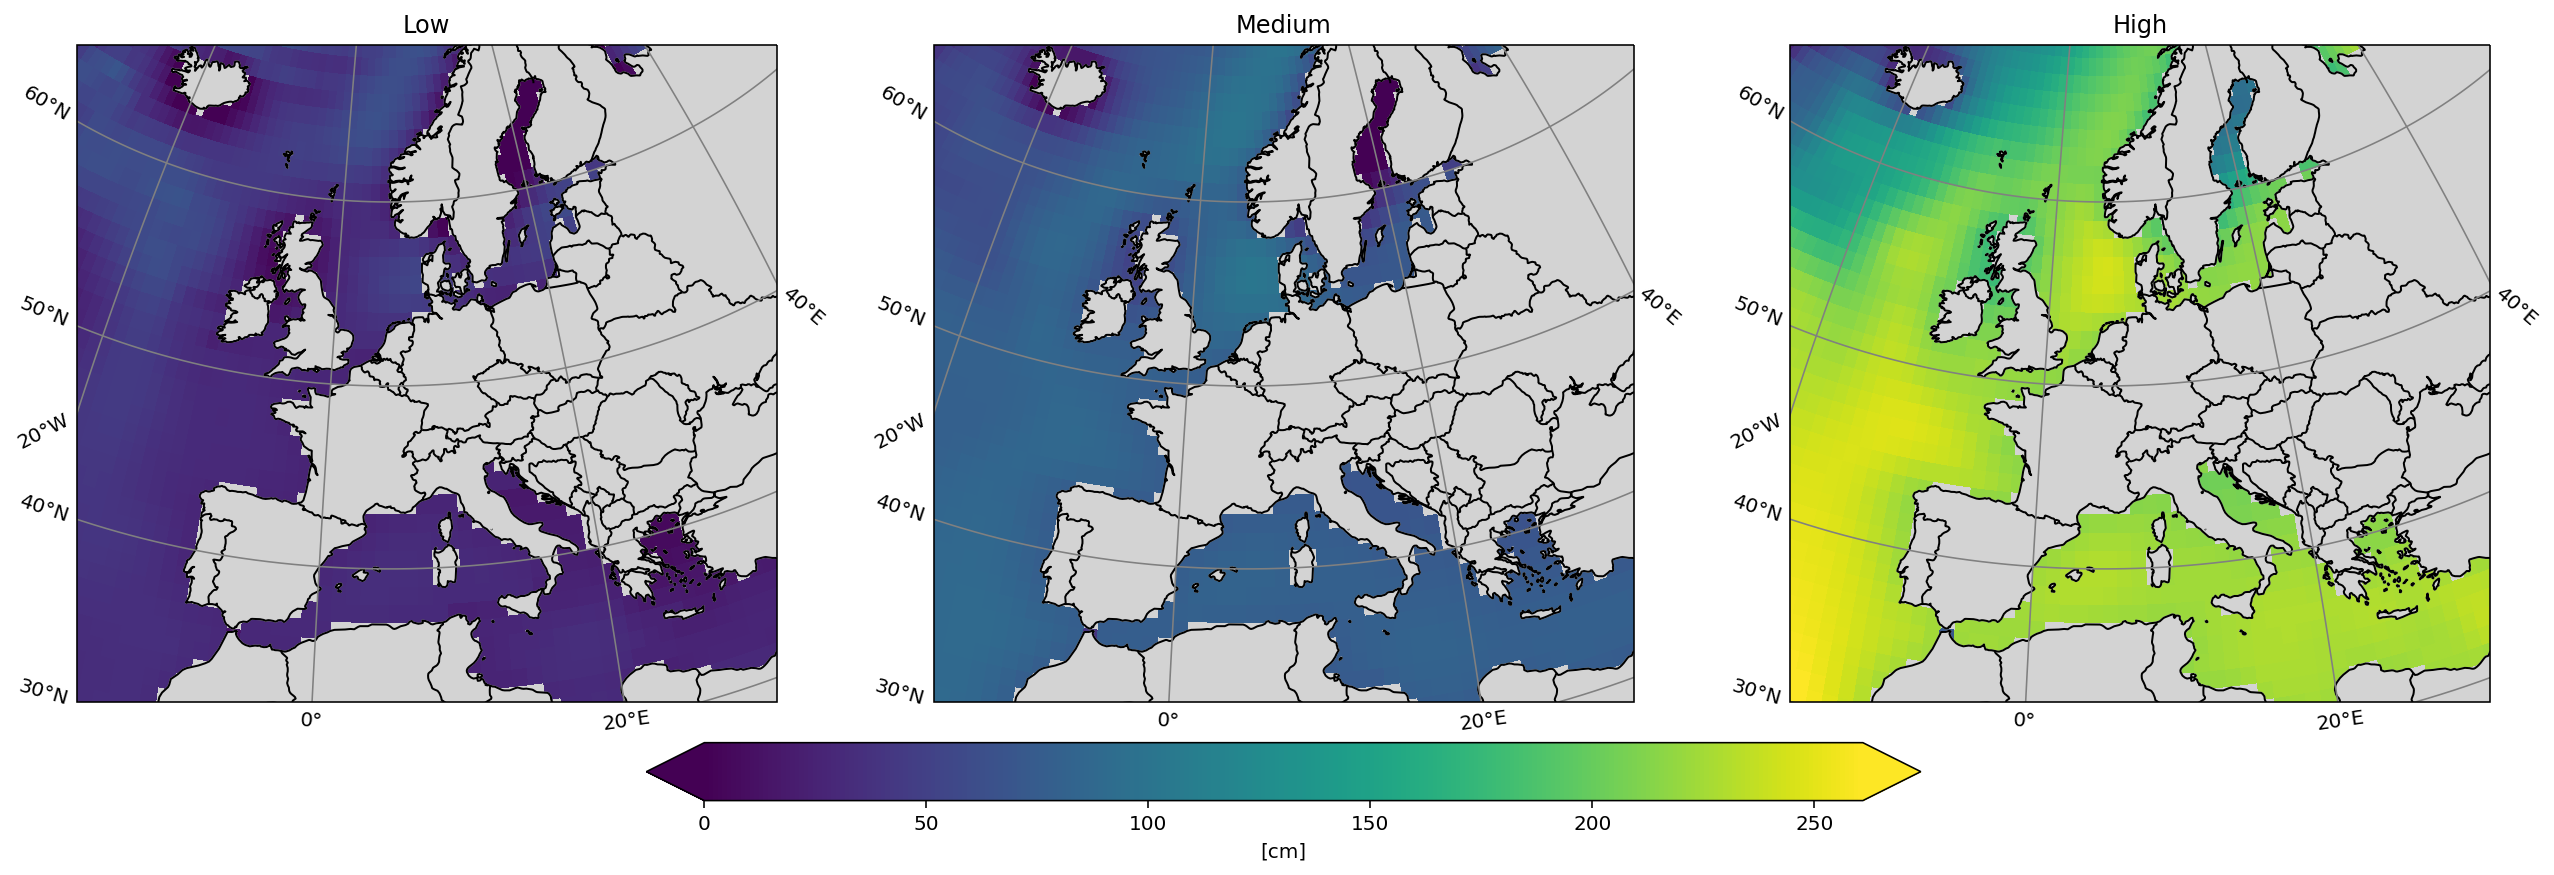

In [16]:
lon_min, lon_max, lat_min, lat_max = -15, 30, 30, 67 #Europe: -15, 30, 30, 67

#g = concat_mean.sel(lat=slice(lat_min,lat_max+2), lon=slice(lon_min-10,lon_max)).plot(
g = proj_map_ds.plot(
    col='proj',
    figsize=(18,6),
    subplot_kws=dict(projection=ccrs.Orthographic(5, 52), facecolor="lightgray"),
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'orientation': 'horizontal', 'label': '[cm]', 'pad': 0.05, 'shrink':0.5},
    robust=True,
    vmin=0,
    )

for i in range(3):
    g.axes[0,i].set_title(proj_names[i]) #Index of axis is line,column 

    g.axes[0,i].add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) #zorder=1    
    g.axes[0,i].add_feature(cfeature.BORDERS)
    g.axes[0,i].coastlines()

    gl = g.axes[0,i].gridlines(color='grey', linestyle='-', draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    g.axes[0,i].set_extent([lon_min, lon_max, lat_min, lat_max])
    
#plt.savefig(f'../figures/CompMapProj_europe.pdf', dpi=100, bbox_inches='tight')


Zoom in further on the area that includes the three regions of interest

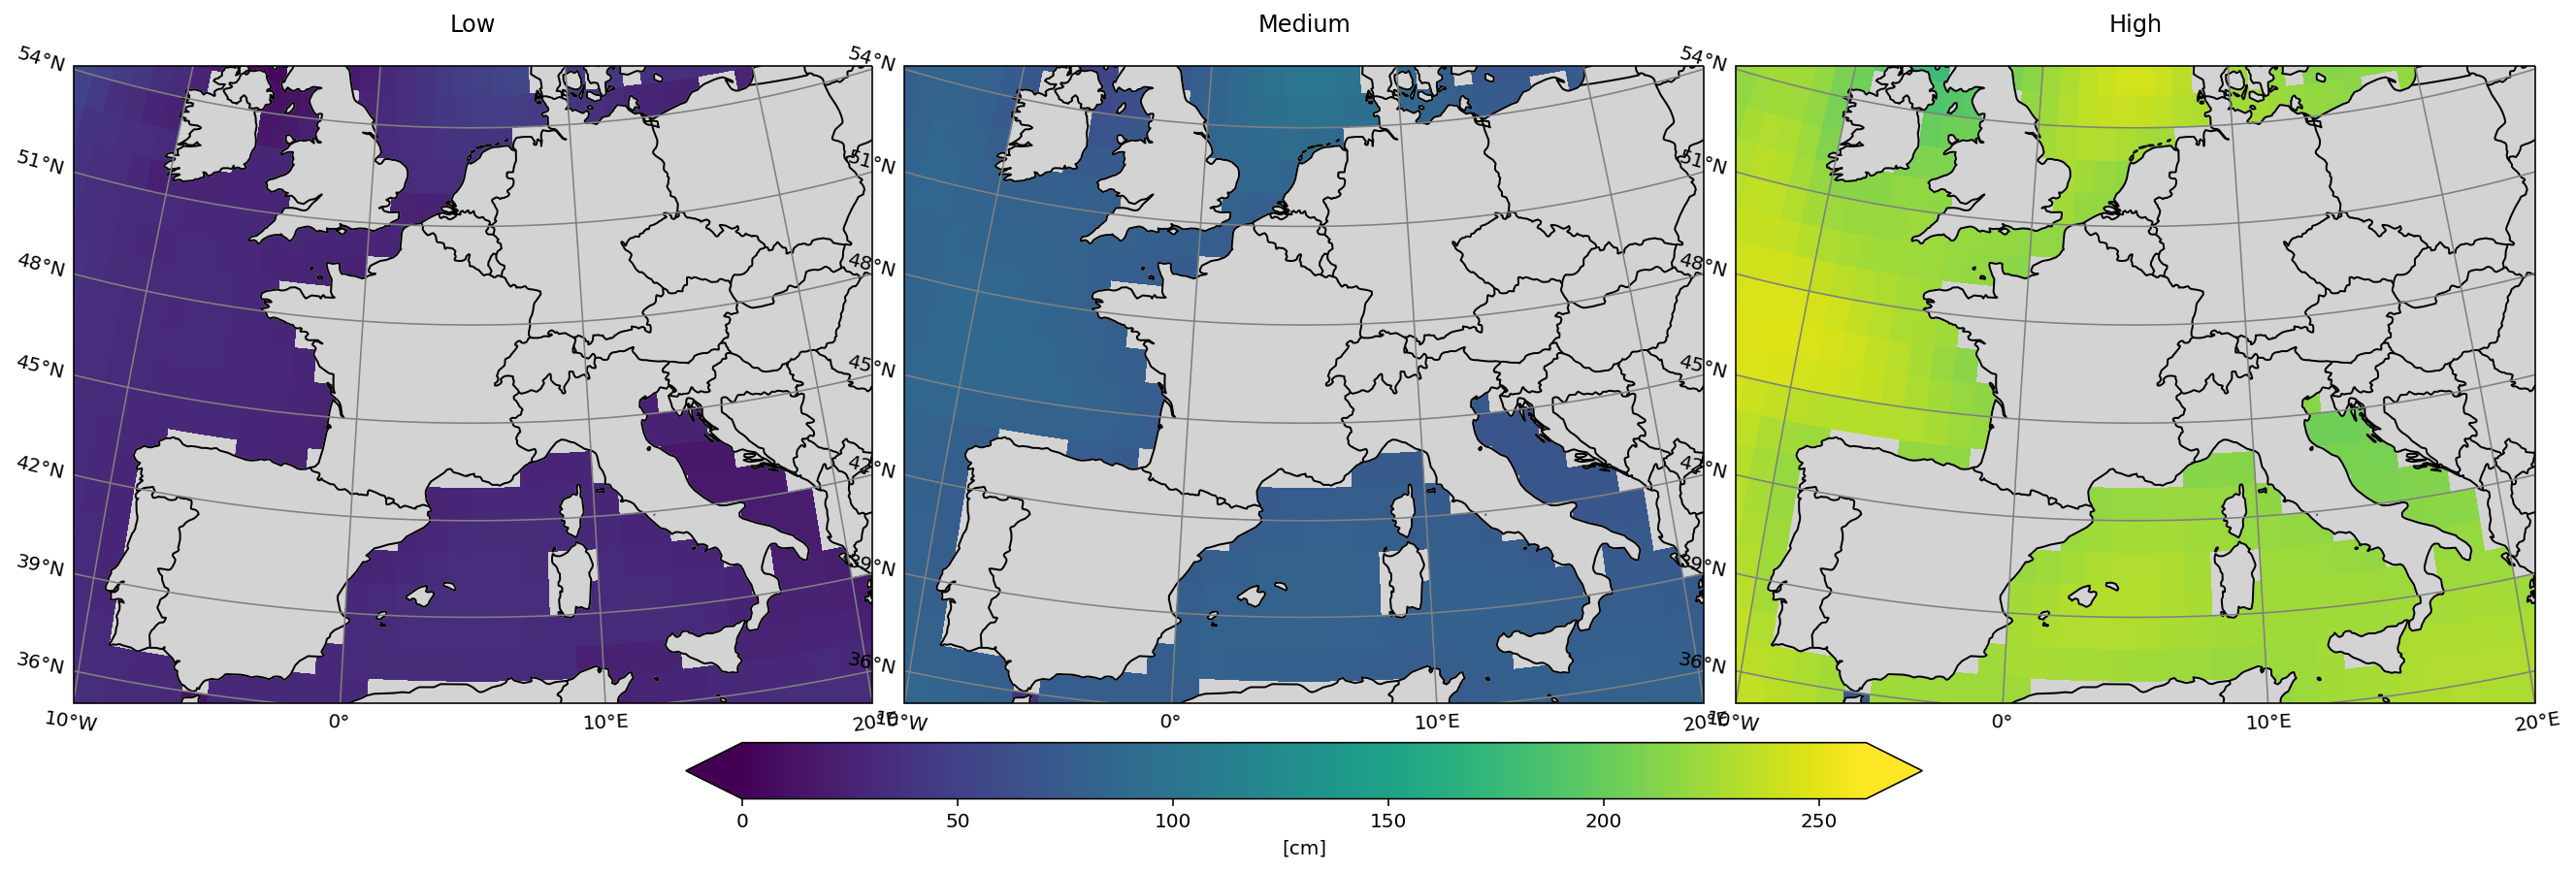

In [29]:
lon_min, lon_max, lat_min, lat_max = -10, 20, 35, 55 #Europe: -15, 30, 30, 67

#g = concat_mean.sel(lat=slice(lat_min,lat_max+2), lon=slice(lon_min-10,lon_max)).plot(
g = proj_map_ds.plot(
    col='proj',
    figsize=(18,6),
    subplot_kws=dict(projection=ccrs.Orthographic(5, 52), facecolor="lightgray"),
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'orientation': 'horizontal', 'label': '[cm]', 'pad': 0.05, 'shrink':0.5},
    robust=True,
    vmin=0,
    )

for i in range(3):
    g.axes[0,i].set_title(proj_names[i]) #Index of axis is line,column 

    g.axes[0,i].add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) #zorder=1    
    g.axes[0,i].add_feature(cfeature.BORDERS)
    g.axes[0,i].coastlines()

    gl = g.axes[0,i].gridlines(color='grey', linestyle='-', draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    g.axes[0,i].set_extent([lon_min, lon_max, lat_min, lat_max])
    

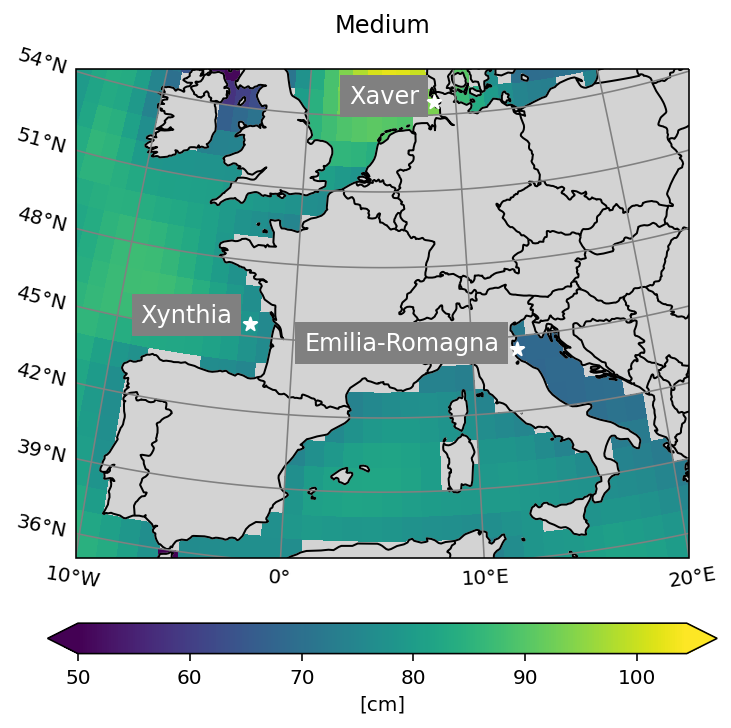

In [62]:
lon_min, lon_max, lat_min, lat_max = -10, 20, 35, 55

proj_name = 'Medium'

plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(5, 52), facecolor="lightgray")

g = proj_map_ds.sel(proj=proj_name).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'orientation': 'horizontal', 'label': '[cm]', 'pad': 0.1},
    robust=True,
    vmin=50,
    )

g.axes.set_title(proj_name) #Index of axis is line,column 

g.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) #zorder=1    
g.axes.add_feature(cfeature.BORDERS)
g.axes.coastlines()

gl = g.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False

for i in range(3):
    plt.text(slr_2120_df.Longitude[i]-1, slr_2120_df.Latitude[i], slr_2120_df.index[i], color='white', 
             transform=ccrs.PlateCarree(), fontsize=12, backgroundcolor='grey',
             horizontalalignment='right')
    plt.scatter(slr_2120_df.Longitude[i], slr_2120_df.Latitude[i], color='white', marker='*', 
             linestyle='None', transform=ccrs.PlateCarree(), s=50, zorder=10)

g.axes.set_extent([lon_min, lon_max, lat_min, lat_max])

#plt.savefig(f'../figures/RECEIPT_ProjEurope.pdf', dpi=100, bbox_inches='tight')

In [37]:
slr_2120_df.index

Index(['Xynthia', 'Xaver', 'Emilia-Romagna'], dtype='object')

### Print some data

Compute sea level rise between the year Xynthia hit the Atlantic coast of France (2010) and 2120 

In [18]:
# Select one grid cell: 
lon_s, lat_s = 12.5, 44.5 # Offshore La Rochelle: -2.5, 45.5
proj_mean_ds = proj_ds.sel(lat=lat_s, lon=lon_s)

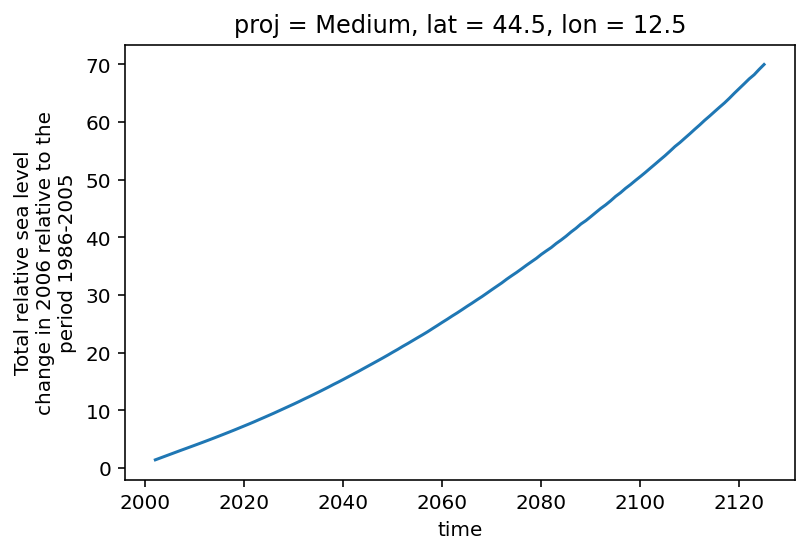

In [19]:
med_sel = proj_mean_ds.TotalSL.sel(proj='Medium')
med_sel.plot()

In [20]:
med_sel.sel(time=2120) - med_sel.sel(time=2010)

<xarray.DataArray 'TotalSL' ()>
array(61.87060407)
Coordinates:
    proj     <U6 'Medium'
    lat      float64 44.5
    lon      float64 12.5

Text(0, 0.5, 'Sea level rise [cm], relative to 1986-2005 ')

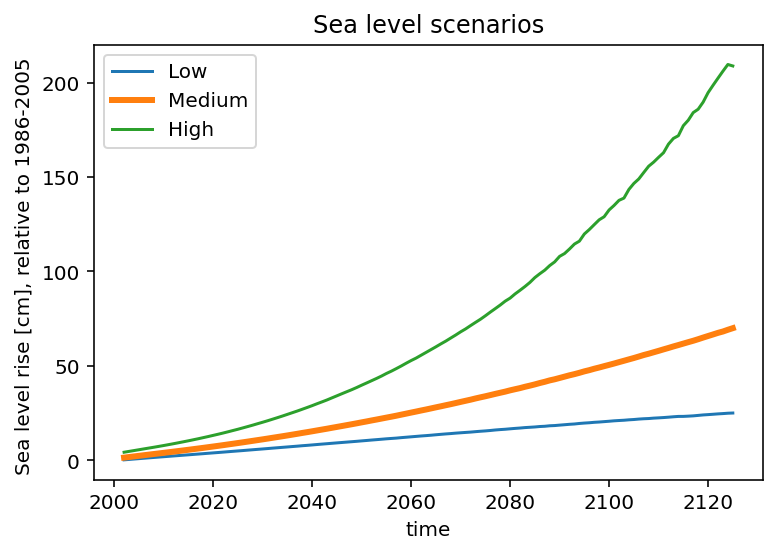

In [21]:
sce_sel = proj_mean_ds.TotalSL

sce_sel.sel(proj='Low').plot()
sce_sel.sel(proj='Medium').plot(linewidth=3)
sce_sel.sel(proj='High').plot()

plt.legend(sce_sel.proj.values)
plt.title('Sea level scenarios')
plt.ylabel('Sea level rise [cm], relative to 1986-2005 ')

#plt.savefig('../figures/SeaLevelScenarios_FrenchCoast.png',dpi=150)

### Format the relevant data for RECEIPT

In [23]:
scen = ['Low', 'Medium', 'High']


dic = {'Low': [], 'Medium': [], 'High': [] }

for idx in slr_2120_df.index:
    df = slr_2120_df.loc[idx]
    proj_mean_ds = proj_ds.sel(lat=df['Latitude'], 
                               lon=df['Longitude'])
    
    for sc in scen:
        ds = proj_mean_ds.TotalSL.sel(proj=sc)
        end_val = ds.sel(time= int(df['Period'].split('-')[1])).values
        start_val = ds.sel(time= int(df['Period'].split('-')[0])).values
        dic[sc].append( round(end_val - start_val) )
         
for sc in scen:
    slr_2120_df[sc] = dic[sc]


In [24]:
slr_2120_df

,Period,Longitude,Latitude,Low,Medium,High
Xynthia,2010-2120,-2.5,45.5,25,71,204
Xaver,2013-2120,8.5,54.5,39,82,211
Emilia-Romagna,2002-2120,12.5,44.5,24,64,190


In [25]:
#path = '/Users/dewilebars/Projects/Project_ProbSLR/SLProj/outputs/data_RECEIPT_D73/'
#slr_2120_df.to_csv(f'{path}SeaLevelData_RECEIPT_CaseStudies.csv')